Grain 1/400 placed at (65,122) axes=(52,17) rough=0.10
Grain 2/400 placed at (168,61) axes=(38,16) rough=0.09
Grain 3/400 placed at (49,41) axes=(30,29) rough=0.06
Grain 4/400 placed at (179,170) axes=(30,20) rough=0.09
Grain 5/400 placed at (129,172) axes=(70,7) rough=0.06
Grain 6/400 placed at (12,172) axes=(5,40) rough=0.06
Grain 7/400 placed at (65,208) axes=(34,12) rough=0.09
Grain 8/400 placed at (233,88) axes=(14,36) rough=0.07
Grain 9/400 placed at (172,116) axes=(13,40) rough=0.05
Grain 10/400 placed at (191,220) axes=(17,14) rough=0.05
Grain 11/400 placed at (140,32) axes=(23,8) rough=0.09
Grain 12/400 placed at (27,93) axes=(15,5) rough=0.08
Grain 13/400 placed at (95,174) axes=(15,26) rough=0.05
Grain 14/400 placed at (214,25) axes=(13,8) rough=0.08
Grain 15/400 placed at (111,64) axes=(20,8) rough=0.09
Grain 16/400 placed at (227,215) axes=(12,6) rough=0.05
Grain 17/400 placed at (58,241) axes=(31,8) rough=0.09
Grain 18/400 placed at (112,14) axes=(14,7) rough=0.08
Grain 1

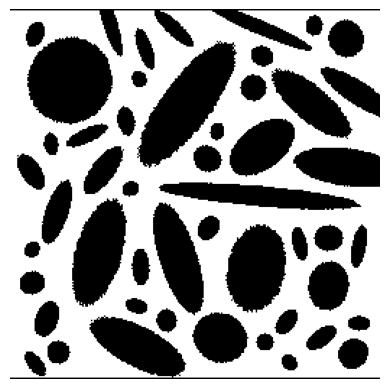

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from scipy.ndimage import binary_dilation

def generate_grain(shape, center, axes, angle=0, roughness=0.15, n_points=200):
    """Generate irregular ellipse mask."""
    t = np.linspace(0, 2*np.pi, n_points)
    x = axes[1] * np.cos(t)
    y = axes[0] * np.sin(t)
    r_noise = 1 + roughness * (np.random.rand(n_points) - 0.5)
    x, y = x * r_noise, y * r_noise
    xr = x*np.cos(angle) - y*np.sin(angle)
    yr = x*np.sin(angle) + y*np.cos(angle)
    rr, cc = polygon(yr + center[0], xr + center[1], shape)
    mask = np.zeros(shape, dtype=bool)
    mask[rr, cc] = True
    return mask

def generate_porous_media_adaptive(Nx=5000, Ny=5000, n_grains=100, buffer=7,
                                    axis_range_y=(20,200), axis_range_x=(20,200),
                                    roughness_range=(0.05,0.25),
                                    angle_range=(0,2*np.pi),
                                    max_attempts=200):
    
    domain = np.ones((Nx, Ny), dtype=np.int32)
    domain[-1, :] = 0
    domain[0, :] = 0
    available = np.ones((Nx, Ny), dtype=bool)
    placed = 0

    sizes_y = np.arange(axis_range_y[1], axis_range_y[0]-1, -1)
    sizes_x = np.arange(axis_range_x[1], axis_range_x[0]-1, -1)

    active_sizes_y = sizes_y.copy()
    active_sizes_x = sizes_x.copy()

    while placed < n_grains and len(active_sizes_x) > 1 and len(active_sizes_y) > 1:
        ay = np.random.choice(active_sizes_y)
        ax = np.random.choice(active_sizes_x)
        cy, cx = np.random.randint(ay+5, Nx-ay-5), np.random.randint(ax+5, Ny-ax-5)

        angle = np.random.uniform(*angle_range)
        rough = np.random.uniform(*roughness_range)

        grain = generate_grain((Nx, Ny), (cy, cx), (ay, ax), angle, rough)

        if np.any(~available[grain]):
            max_attempts -= 1
            if max_attempts <= 0:
                if len(active_sizes_y) > 1:
                    active_sizes_y = active_sizes_y[1:]
                if len(active_sizes_x) > 1:
                    active_sizes_x = active_sizes_x[1:]
                max_attempts = 200
                print(f"Dropping largest sizes → new range Y:{active_sizes_y[0]}-{active_sizes_y[-1]} "
                      f"X:{active_sizes_x[0]}-{active_sizes_x[-1]}")
            continue

        domain[grain] = 0
        placed += 1
        print(f"Grain {placed}/{n_grains} placed at ({cy},{cx}) "
              f"axes=({ay},{ax}) rough={rough:.2f}")

        if buffer > 0:
            taken = binary_dilation(grain, iterations=buffer)
        else:
            taken = grain
        available[taken] = False

    print(f"\nSummary: placed {placed}/{n_grains} grains "
          f"(final active sizes Y:{active_sizes_y[-1]} X:{active_sizes_x[-1]})")
    return domain

Nx = 256
Ny = 256
domain = generate_porous_media_adaptive(Nx=Nx, Ny=Ny, 
                                        n_grains=400, axis_range_x=(5, 100), axis_range_y=(5, 100), 
                                        roughness_range=(0.05, 0.1), buffer=5, max_attempts=50000)

plt.imshow(domain, cmap="gray")
plt.axis("off")
plt.show()

domain_linear = np.reshape(domain, (Nx*Ny, 1), order='F')
np.savetxt("pore_raw.txt", domain_linear, fmt="%i")


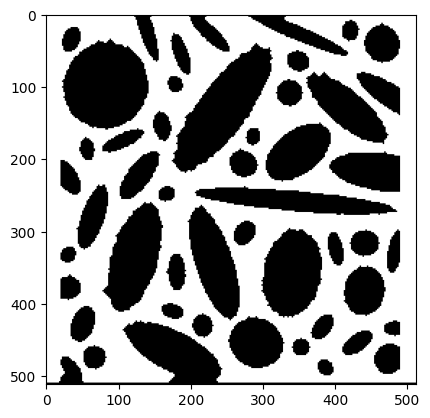

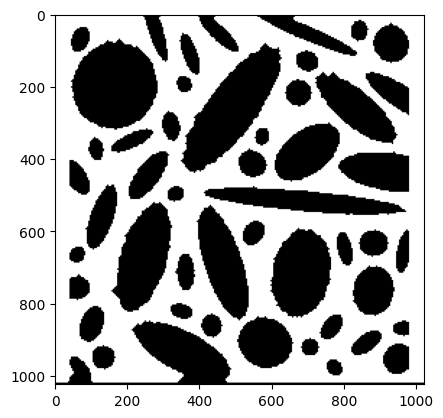

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def upscale_binary_blocky(img, factor=2):
    """
    Upscale a 2D binary image by integer factor using block replication
    (nearest-neighbor). Output contains only 0s and 1s.
    Parameters
    ----------
    img : np.ndarray
        2D numpy array of 0s and 1s (binary image).
    factor : int
        Upscaling factor (e.g. 2 -> doubles width and height).
    Returns
    -------
    np.ndarray
        Upscaled binary image of shape (img.shape[0]*factor, img.shape[1]*factor).
    """
    if factor < 1 or int(factor) != factor:
        raise ValueError("Factor must be a positive integer.")
    return np.kron(img, np.ones((factor, factor), dtype=int))

# ---- Convenience wrapper for your specific case ----
def double_and_quadruple_blocky(img):
    """
    Given a 256x256 binary image (domain 256 nm × 256 nm, 1 nm pixels),
    returns:
      - 512x512 array (0.5 nm resolution)
      - 1024x1024 array (0.25 nm resolution)
    """
    img_512 = upscale_binary_blocky(img, factor=2)
    img_1024 = upscale_binary_blocky(img, factor=4)
    return img_512, img_1024

case = "c5"
img = np.loadtxt(f"../circles/{case}/coarse/pore.dat").reshape((256, 256)).transpose()
img_512, img_1024 = double_and_quadruple_blocky(img)

plt.figure()
plt.imshow(img_512, cmap='gray')

plt.figure()
plt.imshow(img_1024, cmap='gray')

img512_linear = np.reshape(img_512.transpose(), (512 * 512, 1))
np.savetxt(f"../circles/{case}/medium/pore.dat", img512_linear, fmt='%d')

img1024_linear = np.reshape(img_1024.transpose(), (1024 * 1024, 1))
np.savetxt(f"../circles/{case}/fine/pore.dat", img1024_linear, fmt='%d')

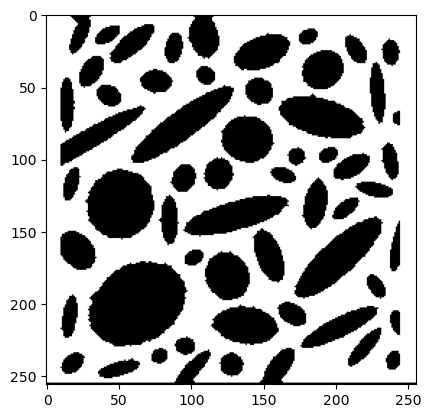

In [23]:
img = np.loadtxt("../circles/c1/pore.dat").reshape((256, 256)).transpose()

plt.figure()
plt.imshow(img, cmap='gray')
